## Import Packages

In [34]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set figure size for plots
rcParams['figure.figsize'] = 12, 6

## Model Selection and Training

In [36]:
data_file_path = '../data/time_series_demo_data.csv'
preprocessed_data_dir_path = '../data/preprocessed'

ts_column = 'sales'
ts_alt_column = 'sales2'

data = pd.read_csv(data_file_path, parse_dates=['date'], index_col='date')

ts_diff = np.load(os.path.join(preprocessed_data_dir_path, 'sales_diff.npy'))
ts_alt_diff = np.load(os.path.join(preprocessed_data_dir_path, 'sales2_diff.npy'))
ts_seasonal_diff = np.load(os.path.join(preprocessed_data_dir_path, 'sales_seasonal_diff.npy'))
ts_alt_seasonal_diff = np.load(os.path.join(preprocessed_data_dir_path, 'sales2_seasonal_diff.npy'))

**Model Selection**: determining appropriate values for p, d, and q. This is typically done by analyzing the ACF (AutoCorrelation Function) and PACF (Partial AutoCorrelation Function) plots.

- **p**: order of the AR term - *number of lagged observations*
- **q**: the degree of differencing -*number of times the data is differencing*
- **r**: the order of the MA term - *size of the moving average window*

In [37]:
def plot_acf_pacf(timeseries, lags=40):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))
   
    # ACF plot
    plot_acf(timeseries, lags=lags, ax=ax1)
    ax1.set_title('Autocorrelation Function (ACF)')
   
    # PACF plot
    plot_pacf(timeseries, lags=lags, ax=ax2)
    ax2.set_title('Partial Autocorrelation Function (PACF)')
    plt.tight_layout()
    plt.show()

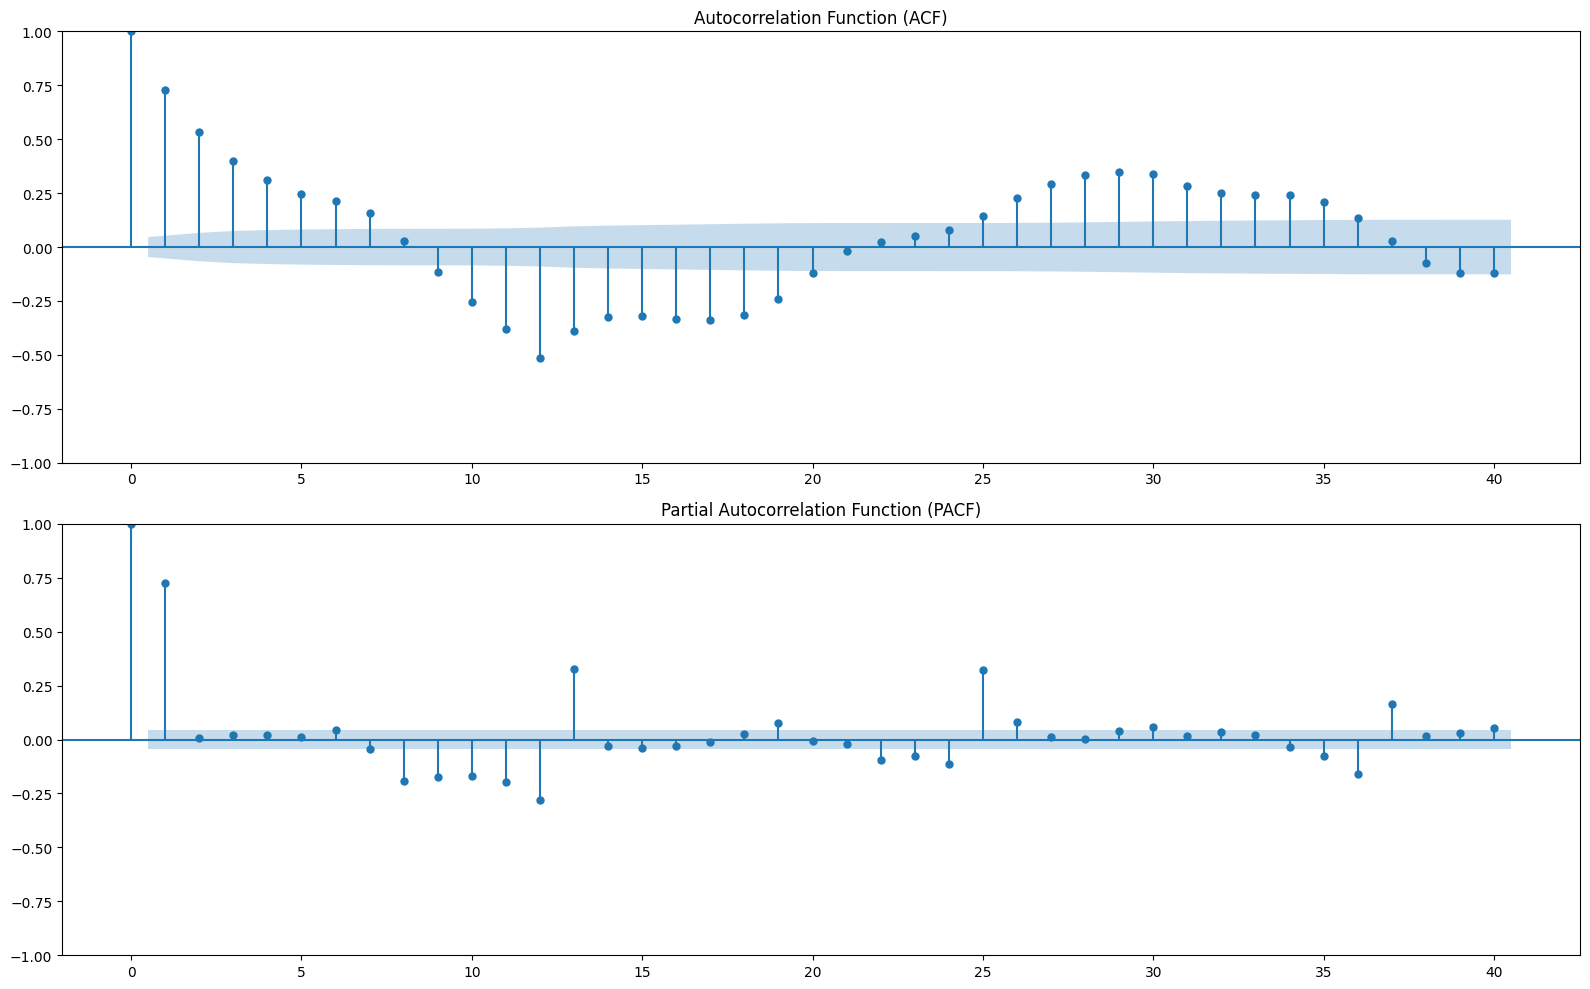

In [38]:
plot_acf_pacf(ts_diff)

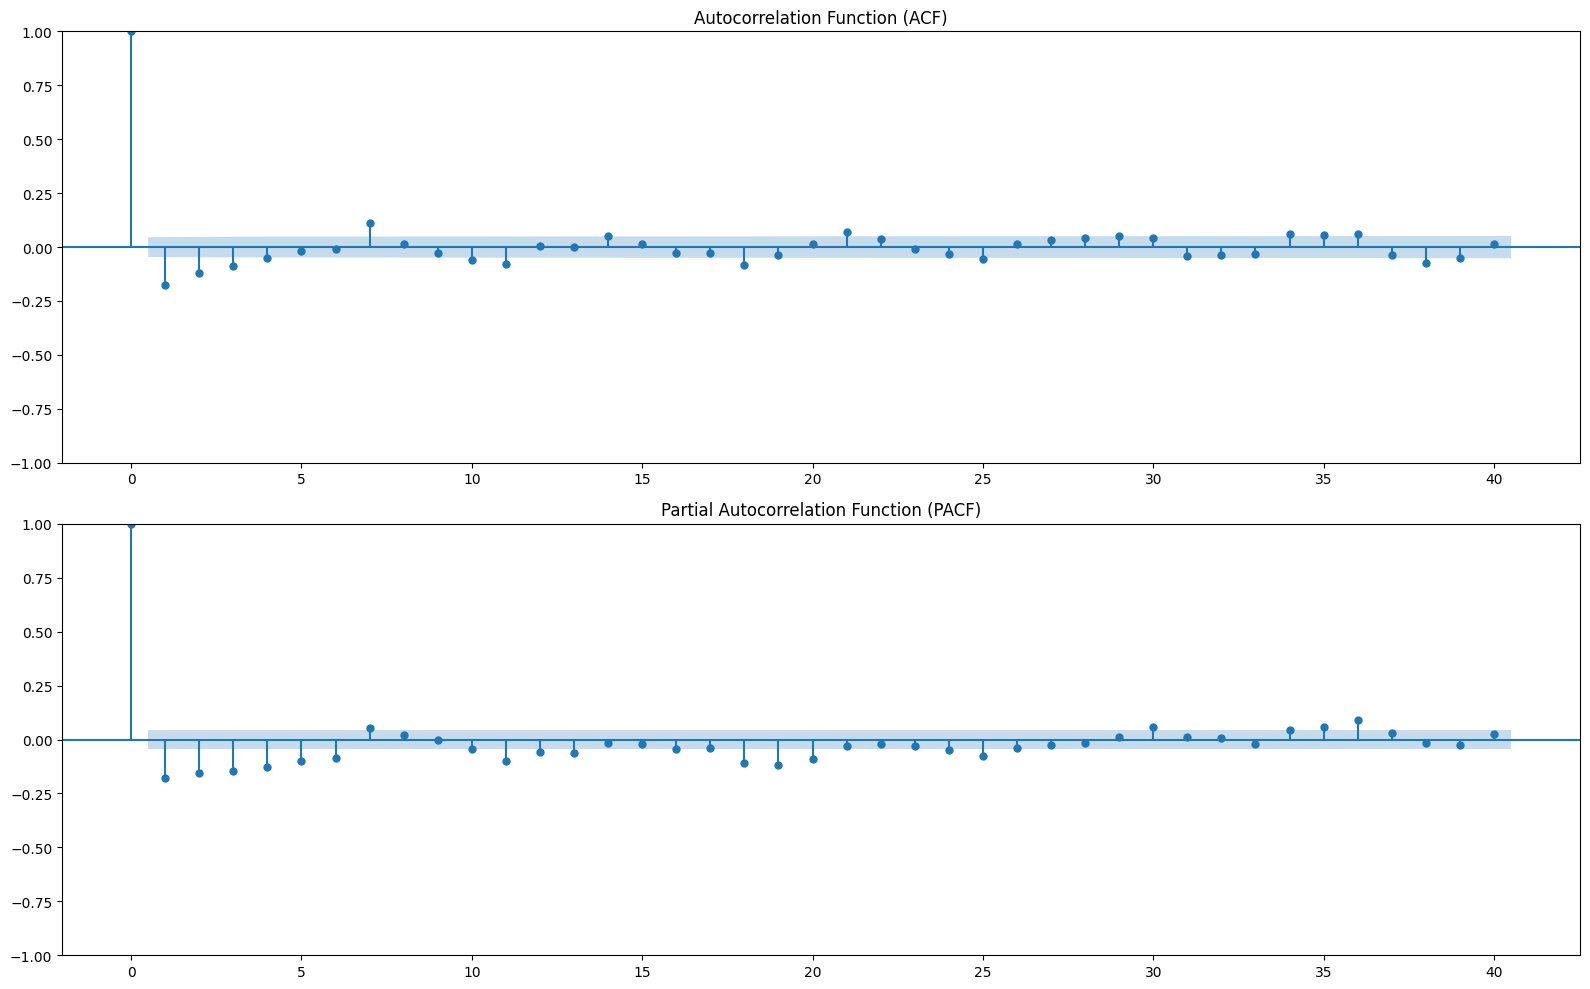

In [6]:
plot_acf_pacf(ts_seasonal_diff)

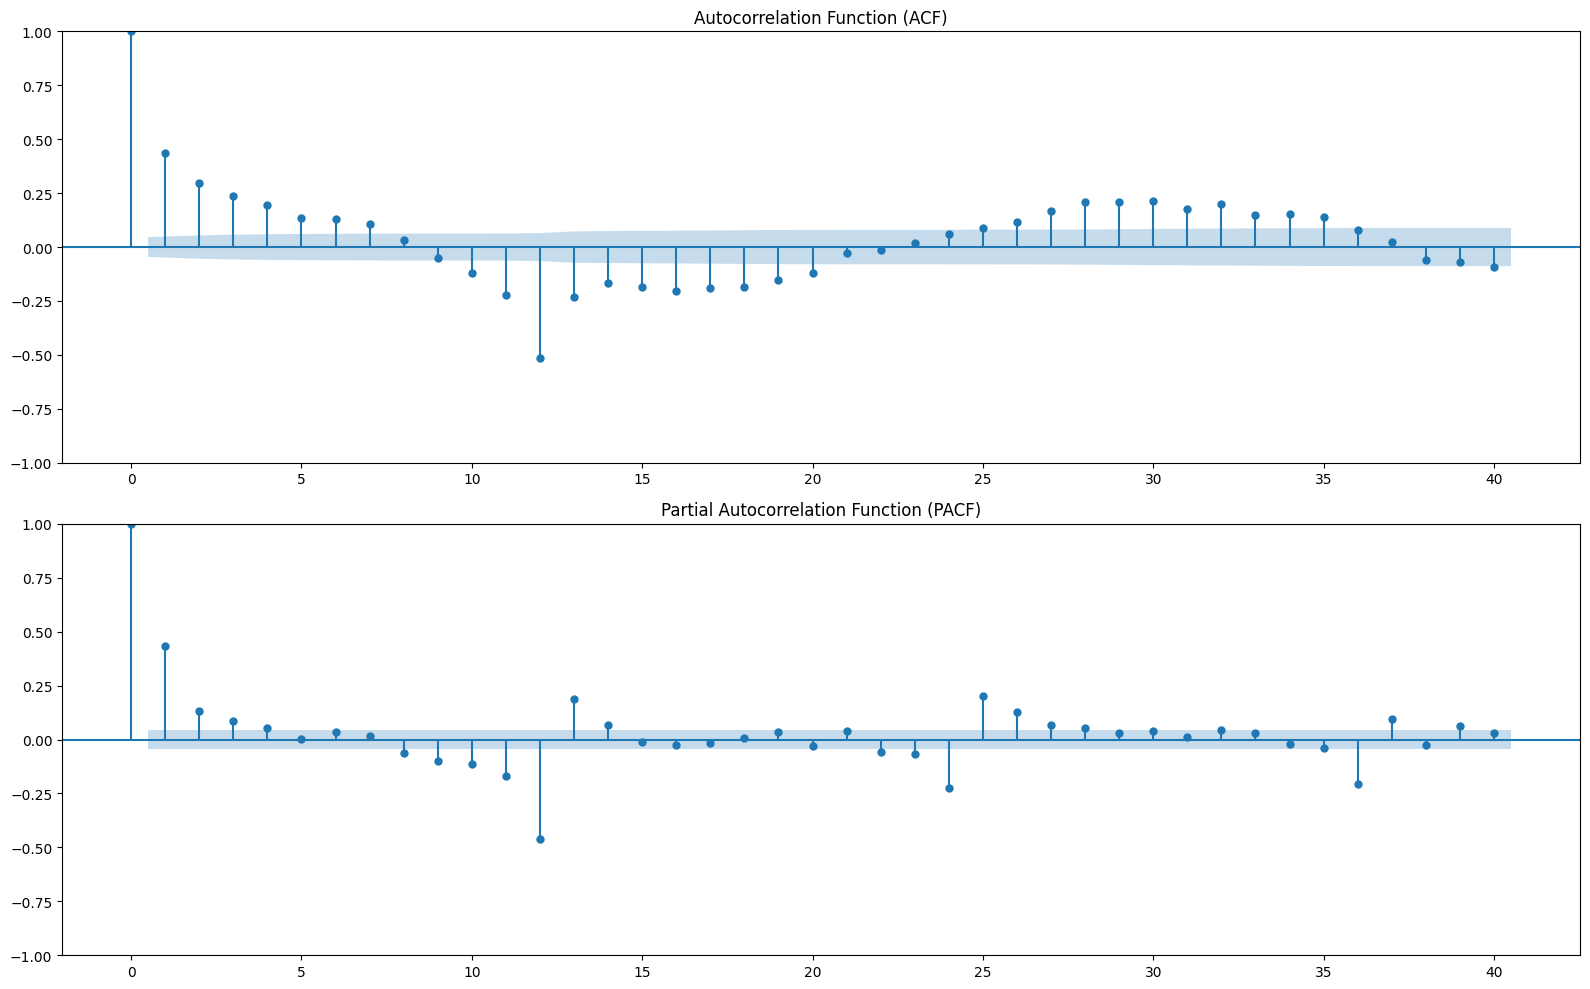

In [7]:
plot_acf_pacf(ts_alt_diff)

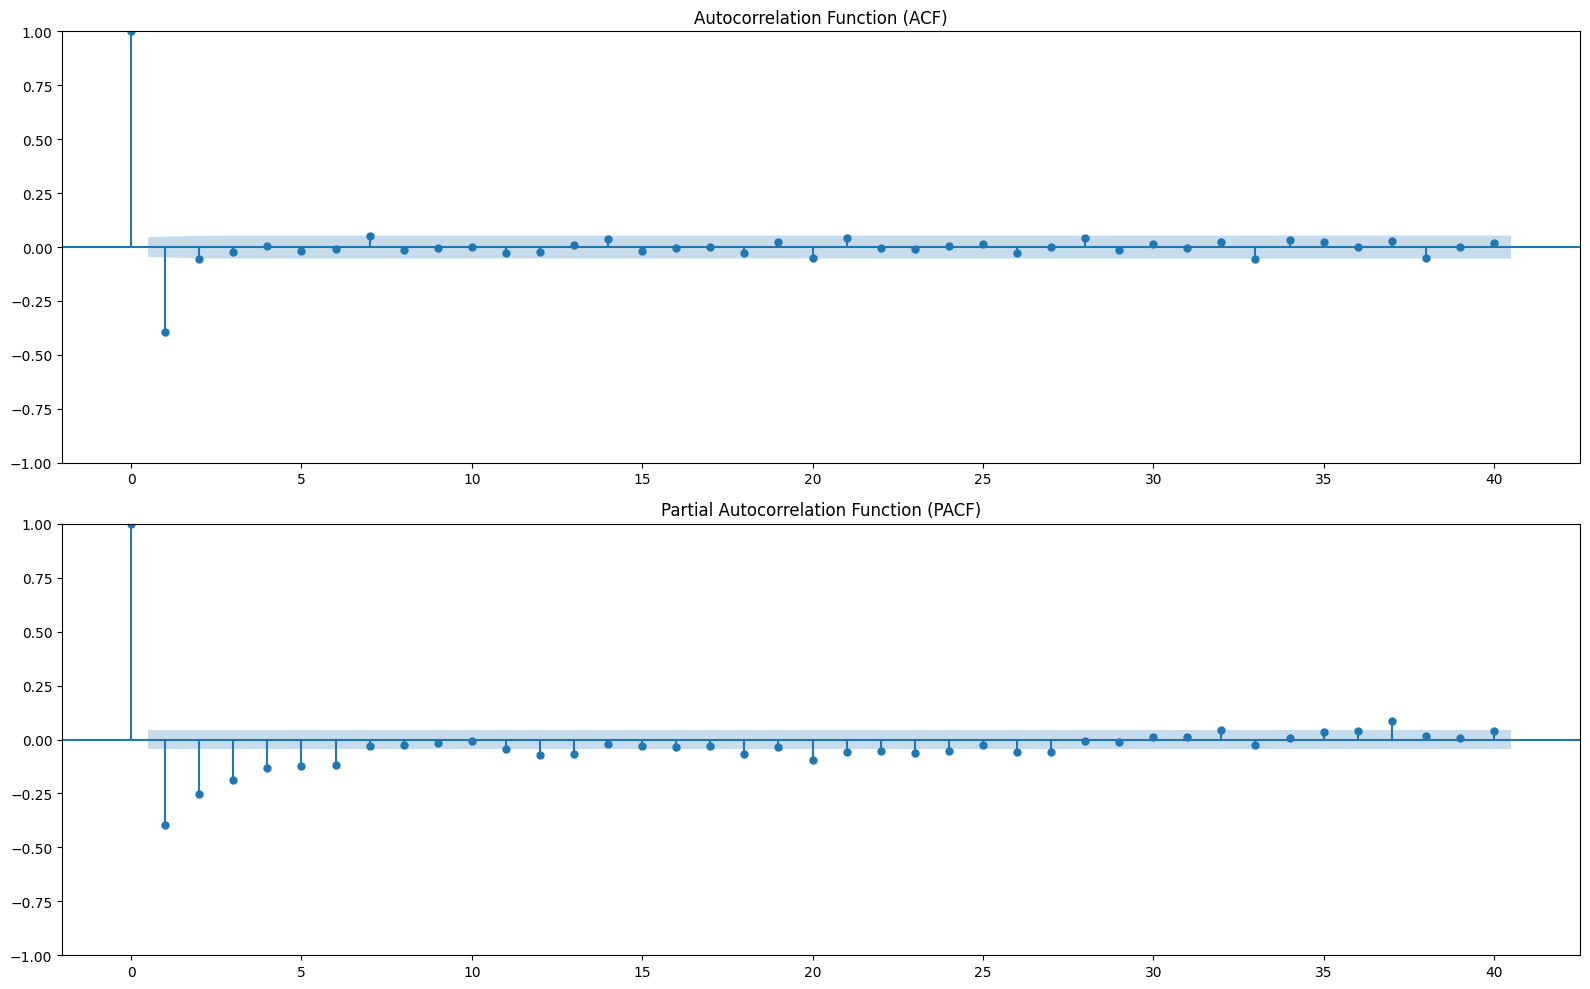

In [8]:
plot_acf_pacf(ts_alt_seasonal_diff)

### Parameter optimization
Grid search and information criteria

In [ ]:
def optimize_arima_parameters(timeseries, p_range, d_range, q_range):
    best_aic = float("inf")
    best_params = None
    best_model = None

    total_iterations = len(p_range) * len(d_range) * len(q_range)
    print(f"Testing {total_iterations} ARIMA configurations")

    for p in p_range:
        for d in d_range:
            for q in q_range:
                try:
                    model = ARIMA(timeseries, order=(p, d, q))
                    results = model.fit()

                    if results.aic < best_aic:
                        best_aic = results.aic
                        best_params = (p, d, q)
                        best_model = results
                        print(f"ARIMA({p},{d},{q}) - AIC: {results.aic}")
                except:
                    continue
    print(f"\nBest ARIMA{best_params} model - AIC: {best_aic}")
    return best_model, best_params

arima, params = optimize_arima_parameters(
    ts_seasonal_diff, 
    p_range=range(0, 4),
    d_range=range(0, 2), 
    q_range=range(0, 4) 
)

Testing 32 ARIMA configurations
ARIMA(0,0,0) - AIC: 14573.106426230897
ARIMA(0,0,1) - AIC: 14485.56856772231
ARIMA(0,0,2) - AIC: 14410.504633397984
ARIMA(0,0,3) - AIC: 14385.172106064889
ARIMA(1,0,1) - AIC: 14360.37009660546

Best ARIMA(1, 0, 1) model - AIC: 14360.37009660546


While **not strictly required**, normally distributed residuals are generally desirable for certain statistical tests and inferences

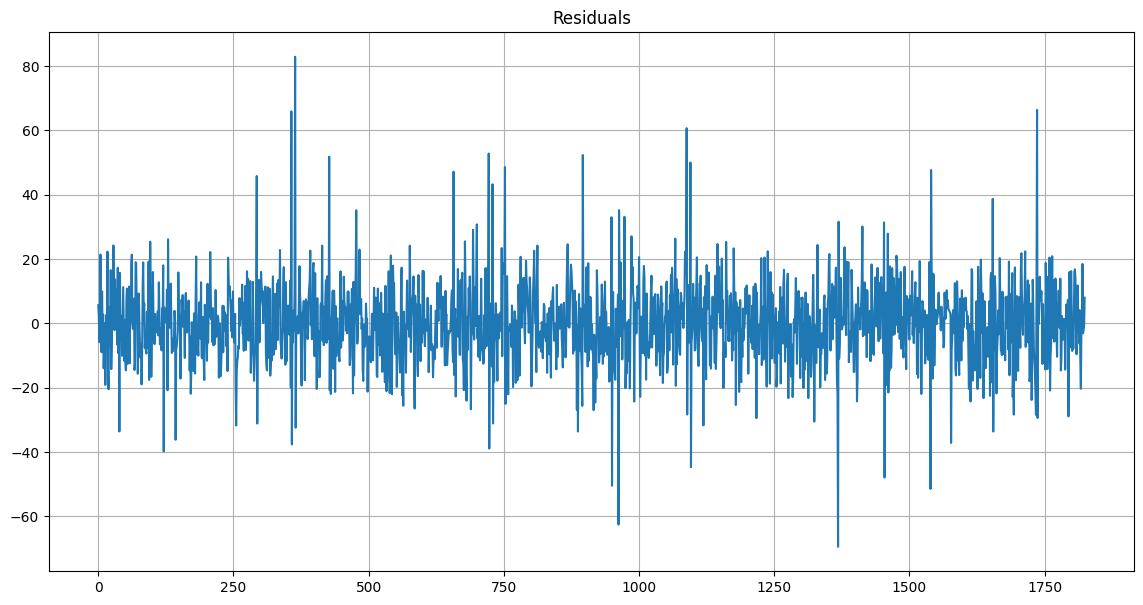

<Figure size 1400x700 with 0 Axes>

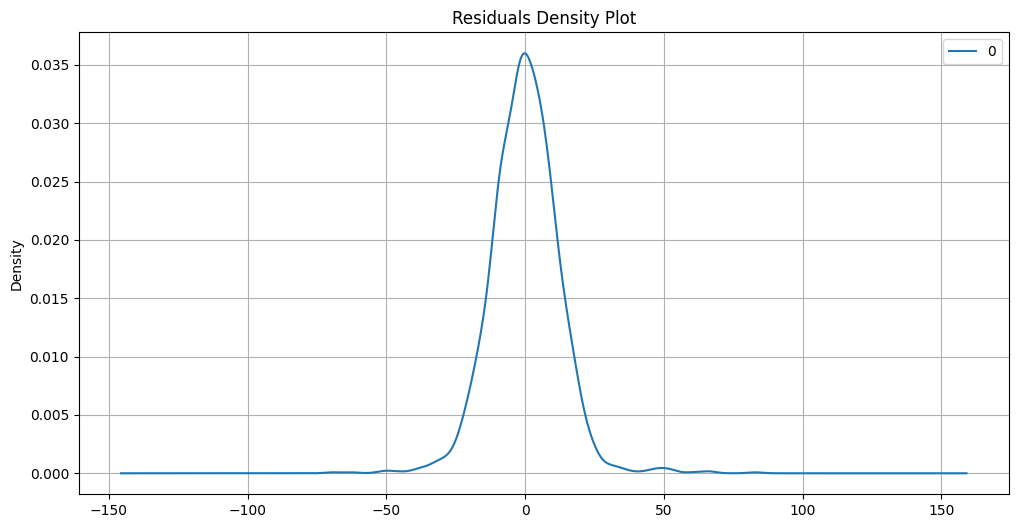

Residuals Summary Statistics:
                 0
count  1825.000000
mean      0.002401
std      12.346938
min     -69.437384
25%      -7.612358
50%      -0.213938
75%       7.255402
max      82.869888

Ljung-Box Test Results:
    Test Statistic   p-value
1         0.094581  0.758432
2         0.171514  0.917817
3         0.319677  0.956286
4         0.352785  0.986157
5         1.451665  0.918579
6         2.871200  0.824830
7        29.491051  0.000118
8        30.605276  0.000165
9        31.840601  0.000212
10       40.491568  0.000014

Shapiro-Wilk Test for Normality:
Test Statistic: 0.9613245030513248
p-value: 1.1790968422503875e-21
Residuals do not appear to be normally distributed


In [22]:
def validate_model(model):
    residuals = pd.DataFrame(model.resid)
    
    plt.figure(figsize=(14, 7))
    plt.plot(residuals)
    plt.title('Residuals')
    plt.grid(True)
    plt.show()
    
    plt.figure(figsize=(14, 7))
    residuals.plot(kind='kde')
    plt.title('Residuals Density Plot')
    plt.grid(True)
    plt.show()
    
    print("Residuals Summary Statistics:")
    print(residuals.describe())
    
    # Perform Ljung-Box test to check for autocorrelation in residuals
    from statsmodels.stats.diagnostic import acorr_ljungbox
    lb_test = acorr_ljungbox(residuals, lags=10)
    
    print("\nLjung-Box Test Results:")
    print(pd.DataFrame({
        'Test Statistic': lb_test['lb_stat'],
        'p-value': lb_test['lb_pvalue']
    }))
    
    # Check for normality of residuals (Shapiro-Wilk test)
    shapiro_test = stats.shapiro(residuals)
    print("\nShapiro-Wilk Test for Normality:")
    print(f"Test Statistic: {shapiro_test[0]}")
    print(f"p-value: {shapiro_test[1]}")
    if shapiro_test[1] > 0.05:
        print("Residuals appear to be normally distributed")
    else:
        print("Residuals do not appear to be normally distributed")

validate_model(arima)

Missing values before handling: sales               36
temperature          0
marketing_spend      0
competitor_price     0
promotion            0
month                0
day_of_week          0
day_of_year          0
is_weekend           0
sales2              36
dtype: int64
Missing values after handling: sales               0
temperature         0
marketing_spend     0
competitor_price    0
promotion           0
month               0
day_of_week         0
day_of_year         0
is_weekend          0
sales2              0
dtype: int64


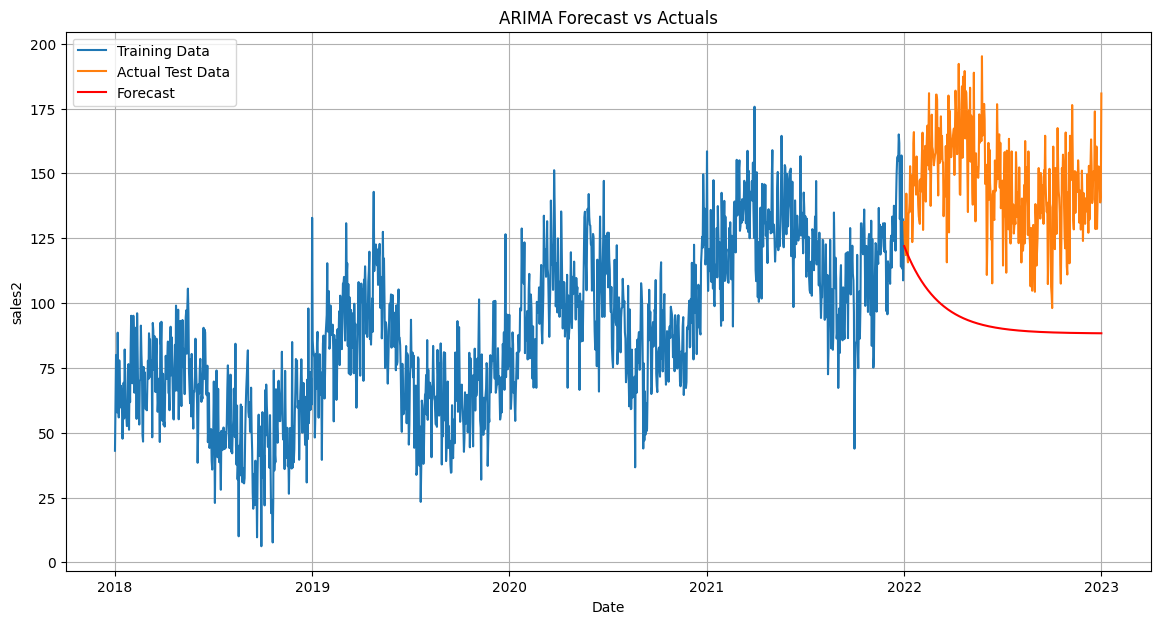

Mean Squared Error (MSE): 3058.405802025078
Root Mean Squared Error (RMSE): 55.30285527913616
Mean Absolute Error (MAE): 52.01404009919388
Mean Absolute Percentage Error (MAPE): 34.687921099894595%


In [33]:
def handle_missing_values(data):
    missing_values = data.isnull().sum()
    print(f"Missing values before handling: {missing_values}")
    
    # Forward fill
    # data_ffill = data.fillna(method='ffill')
    
    # Backward fill
    # data_bfill = data.fillna(method='bfill')
    
    # Linear interpolation
    #  data_interp = data.interpolate(method='linear')
    
    # Time-based interpolation
    data_time_interp = data.interpolate(method='time')
    missing_values = data_time_interp.isnull().sum()
    print(f"Missing values after handling: {missing_values}")
    return data_time_interp

def test_arima_on_holdout(data, column_name, train_size=0.8, order=(1, 0, 1)):
    train_size = int(len(data) * train_size)
    train, test = data[:train_size], data[train_size:]
    
    model = ARIMA(train[column_name], order=order)
    model_fit = model.fit()
    
    forecast = model_fit.forecast(steps=len(test))
    results = pd.DataFrame({
        'Actual': test[column_name],
        'Predicted': forecast
    })
    # Plot actual vs forecast
    plt.figure(figsize=(14, 7))
    plt.plot(train[column_name], label='Training Data')
    plt.plot(test.index, results['Actual'], label='Actual Test Data')
    plt.plot(test.index, results['Predicted'], label='Forecast', color='red')
    plt.title('ARIMA Forecast vs Actuals')
    plt.xlabel('Date')
    plt.ylabel(column_name)
    plt.legend()
    plt.grid(True)
    plt.show()

    # Calculate error metrics
    mse = mean_squared_error(results['Actual'], results['Predicted'])
    rmse = sqrt(mse)
    mae = mean_absolute_error(results['Actual'], results['Predicted'])
    mape = np.mean(np.abs((results['Actual'] - results['Predicted']) / results['Actual'])) * 100
    print(f'Mean Squared Error (MSE): {mse}')
    print(f'Root Mean Squared Error (RMSE): {rmse}')
    print(f'Mean Absolute Error (MAE): {mae}')
    print(f'Mean Absolute Percentage Error (MAPE): {mape}%')
    return results, model_fit

data_missing_values_handled = handle_missing_values(data)
results, model_fit = test_arima_on_holdout(data_missing_values_handled, ts_alt_column)

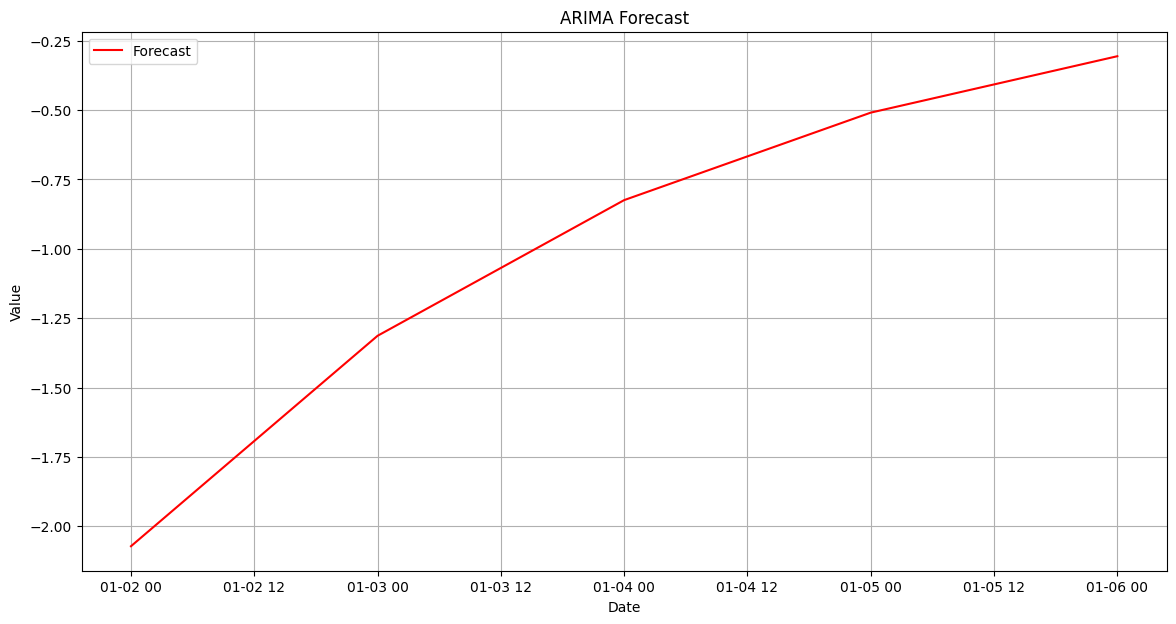

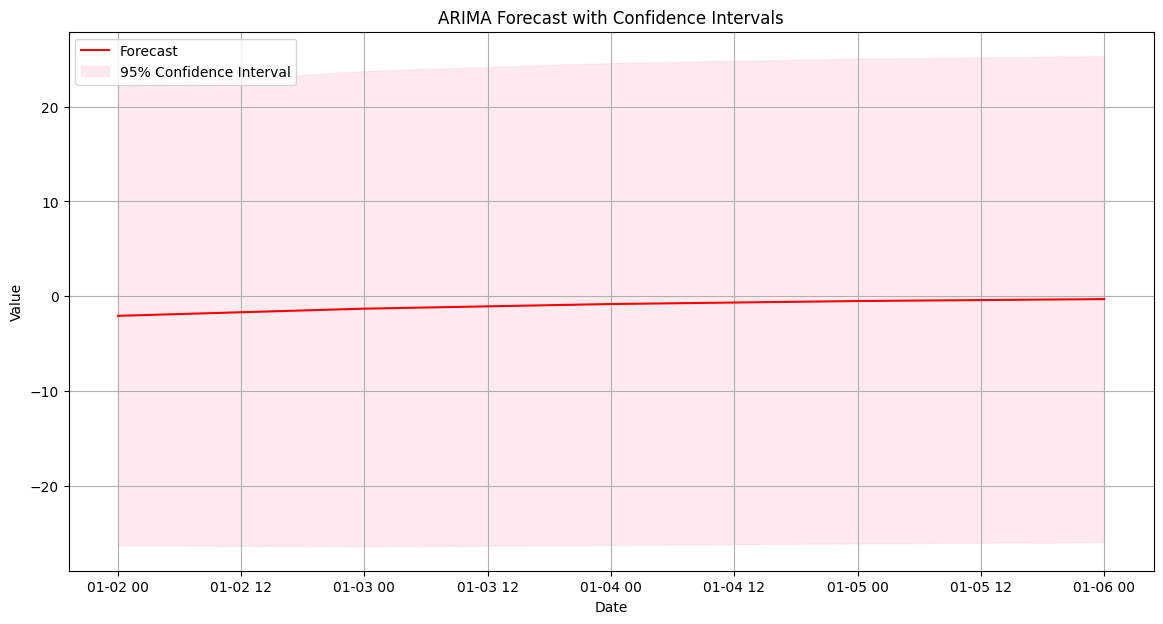

,Forecast,Lower CI,Upper CI
2023-01-02,-2.072249,-26.263264,22.118766
2023-01-03,-1.313543,-26.380932,23.753847
2023-01-04,-0.824347,-26.247188,24.598493
2023-01-05,-0.508926,-26.078086,25.060234
2023-01-06,-0.305550,-25.935295,25.324194


In [12]:
def forecast_future(
        model, 
        steps, 
        original_index, 
        frequency='D'  # daily (M for monthly)
    ): 
    forecast = model.forecast(steps=steps)
    last_date = original_index[-1]
    forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=steps, freq=frequency)
    forecast_df = pd.DataFrame(
        {
            'Forecast': forecast
        }, 
        index=forecast_dates
    )
    historical_data = model.model.data.orig_endog
    if len(original_index) != len(historical_data):
        # Use the shorter length to avoid dimension mismatch
        min_length = min(len(original_index), len(historical_data))
        original_index_aligned = original_index[-min_length:]
        historical_data_aligned = historical_data[-min_length:]
    else:
        original_index_aligned = original_index
        historical_data_aligned = historical_data
    plt.figure(figsize=(14, 7))
    # plt.plot(original_index_aligned, historical_data_aligned, label='Historical Data')
    plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecast', color='red')
    plt.title('ARIMA Forecast')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

    pred_conf = model.get_forecast(steps=steps).conf_int()
    lower_conf = pred_conf[:, 0]
    upper_conf = pred_conf[:, 1]
    plt.figure(figsize=(14, 7))
    # plt.plot(original_index_aligned, historical_data_aligned, label='Historical Data')
    plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecast', color='red')
    plt.fill_between(forecast_df.index,
        lower_conf,
        upper_conf,
        color='pink', 
        alpha=0.3, 
        label='95% Confidence Interval'
    )
    plt.title('ARIMA Forecast with Confidence Intervals')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

    forecast_df['Lower CI'] = lower_conf
    forecast_df['Upper CI'] = upper_conf
    return forecast_df

forecast_df = forecast_future(arima, 5, data.index)
forecast_df.head()

## Seasonal ARIMA (SARIMA)

Extends ARIMA to handle seasonal components. The model is denoted as `SARIMA(p,d,q)(P,D,Q,s)` where:<br>
- `p,d,q`: Non seasonal components
- `P,D,Q`: Seasonal components
- `s`: Seasonality period (eg. 12 for monthly data)

Missing values before handling: sales               36
temperature          0
marketing_spend      0
competitor_price     0
promotion            0
month                0
day_of_week          0
day_of_year          0
is_weekend           0
sales2              36
dtype: int64
Missing values after handling: sales               0
temperature         0
marketing_spend     0
competitor_price    0
promotion           0
month               0
day_of_week         0
day_of_year         0
is_weekend          0
sales2              0
dtype: int64
                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                 1814
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood               -7201.107
Date:                            Tue, 20 May 2025   AIC                          14412.213
Time:                                    13:50:38   BIC                          14439.730
Sample

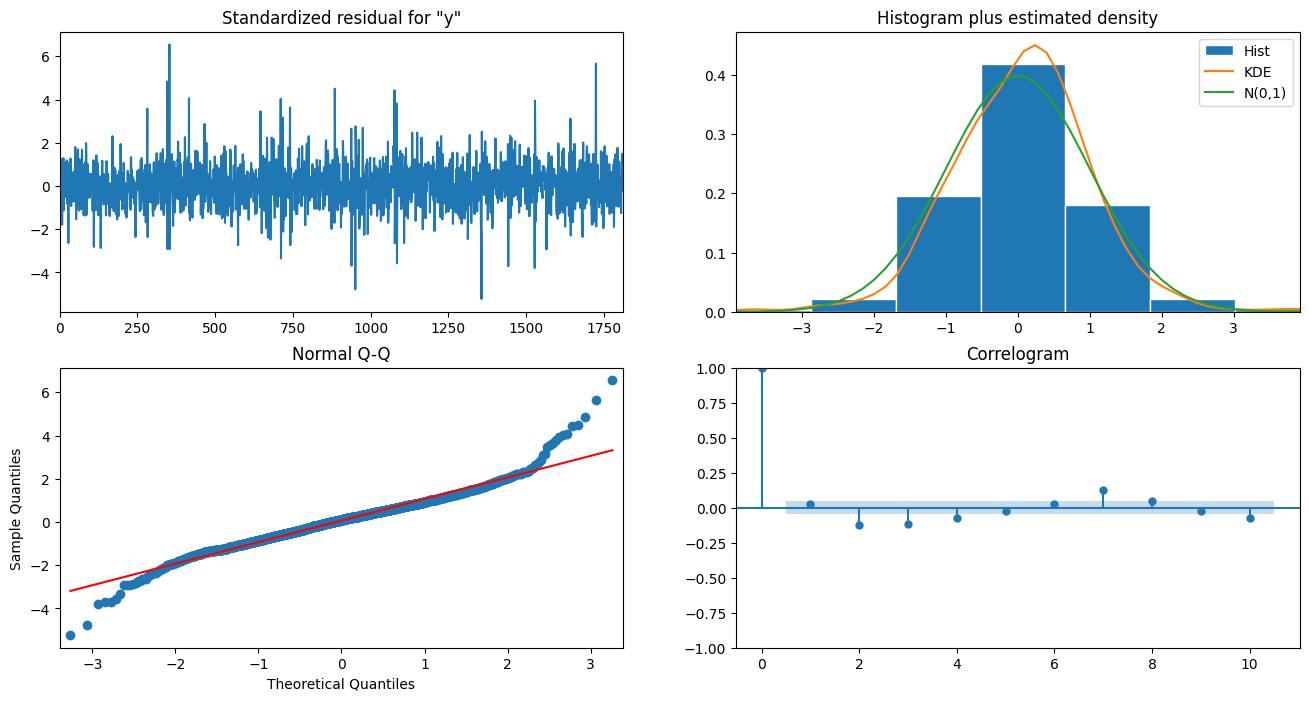

In [13]:
def fit_sarima_model(endog, order, seasonal_order):
    model = SARIMAX(endog, order=order, seasonal_order=seasonal_order)

    results = model.fit()
    print(results.summary())

    results.plot_diagnostics(figsize=(16, 8))
    plt.show()
    return model

data_missing_values_handled = handle_missing_values(data)
sarima = fit_sarima_model(
    endog=ts_diff, 
    # exog=data_missing_values_handled['temperature'], 
    order=(1, 0, 1), 
    seasonal_order=(1, 0, 1, 12)
)

In [ ]:
def optimize_sarimax_parameters(timeseries, p, d, q, P_range, D_range, Q_range, s):
    best_aic = float("inf")
    best_params = None
    best_model = None
    
    total_iterations = len(P_range) * len(D_range) * len(Q_range)
    print(f"Testing {total_iterations} SARIMAX configurations with seasonal={s}")
    
    counter = 0
    for P in P_range:
        for D in D_range:
            for Q in Q_range:
                counter += 1
                if counter % 10 == 0:
                    print(f"Progress: {counter}/{total_iterations} configurations tested")
                    
                # Skip if all parameters are 0
                if p + d + q + P + D + Q == 0:
                    continue
                    
                try:
                    model = SARIMAX(
                        timeseries,
                        order=(p, d, q),
                        seasonal_order=(P, D, Q, s),
                        enforce_stationarity=False,
                        enforce_invertibility=False
                    )
                    results = model.fit(disp=False, maxiter=200)
                    
                    if results.aic < best_aic:
                        best_aic = results.aic
                        best_params = (p, d, q, P, D, Q, s)
                        best_model = results
                        print(f"SARIMA({p},{d},{q})({P},{D},{Q},{s}) - AIC: {results.aic:.4f}")
                except:
                    continue
    
    if best_model is not None:
        print(f"\nBest SARIMA{best_params} model - AIC: {best_aic:.4f}")
    else:
        print("No suitable SARIMAX model found.")
        
    return best_model, best_params

sarima, params = optimize_sarimax_parameters(
    ts_diff,
    p=1, 
    d=0, 
    q=1, 
    P_range=range(0, 4), 
    D_range=range(0, 2), 
    Q_range=range(0, 4), 
    s=12
)

Testing 32 SARIMAX configurations with seasonal=12
SARIMA(1,0,1)(0,0,0,12) - AIC: 15462.4511
SARIMA(1,0,1)(0,0,1,12) - AIC: 14309.1071
SARIMA(1,0,1)(0,0,2,12) - AIC: 14212.0176
SARIMA(1,0,1)(0,0,3,12) - AIC: 14116.3360
Progress: 10/32 configurations tested
SARIMA(1,0,1)(1,0,3,12) - AIC: 14109.8805
Progress: 20/32 configurations tested
SARIMA(1,0,1)(2,0,3,12) - AIC: 14055.3019
Progress: 30/32 configurations tested

Best SARIMA(1, 0, 1, 2, 0, 3, 12) model - AIC: 14055.3019


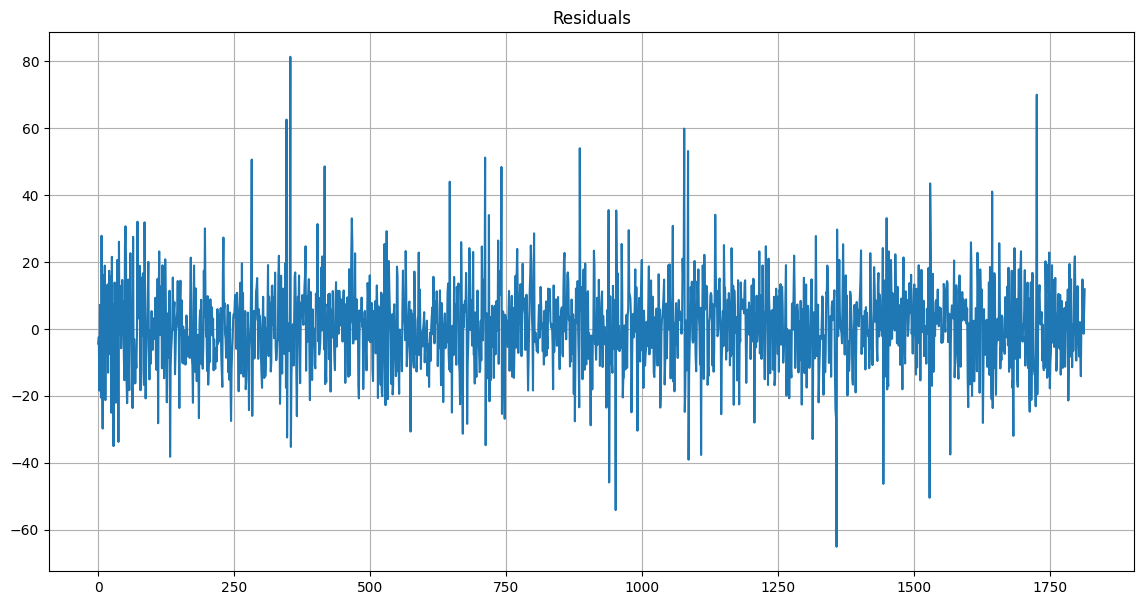

<Figure size 1400x700 with 0 Axes>

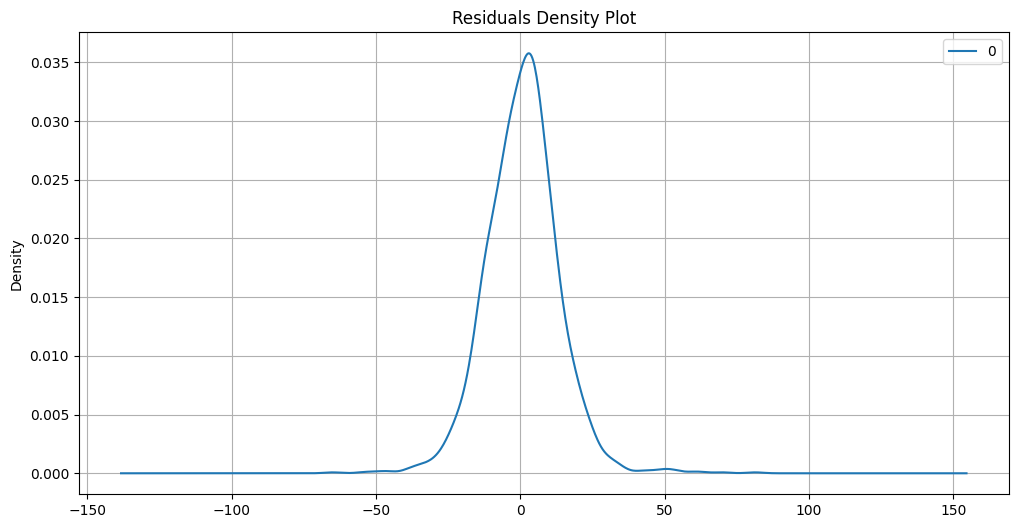

Residuals Summary Statistics:
                 0
count  1814.000000
mean      0.771927
std      12.677627
min     -65.074280
25%      -7.142475
50%       1.113314
75%       8.024920
max      81.347097

Ljung-Box Test Results:
    Test Statistic   p-value
1         0.539266  0.462737
2        21.373142  0.000023
3        28.280768  0.000003
4        30.486553  0.000004
5        30.521760  0.000012
6        30.598765  0.000030
7        32.932540  0.000027
8        32.943731  0.000063
9        33.324401  0.000117
10       33.502987  0.000224

Shapiro-Wilk Test for Normality:
Test Statistic: 0.9716020221984909
p-value: 1.8303738447220664e-18
Residuals do not appear to be normally distributed


In [21]:
validate_model(sarima)

Missing values before handling: sales               36
temperature          0
marketing_spend      0
competitor_price     0
promotion            0
month                0
day_of_week          0
day_of_year          0
is_weekend           0
sales2              36
dtype: int64
Missing values after handling: sales               0
temperature         0
marketing_spend     0
competitor_price    0
promotion           0
month               0
day_of_week         0
day_of_year         0
is_weekend          0
sales2              0
dtype: int64


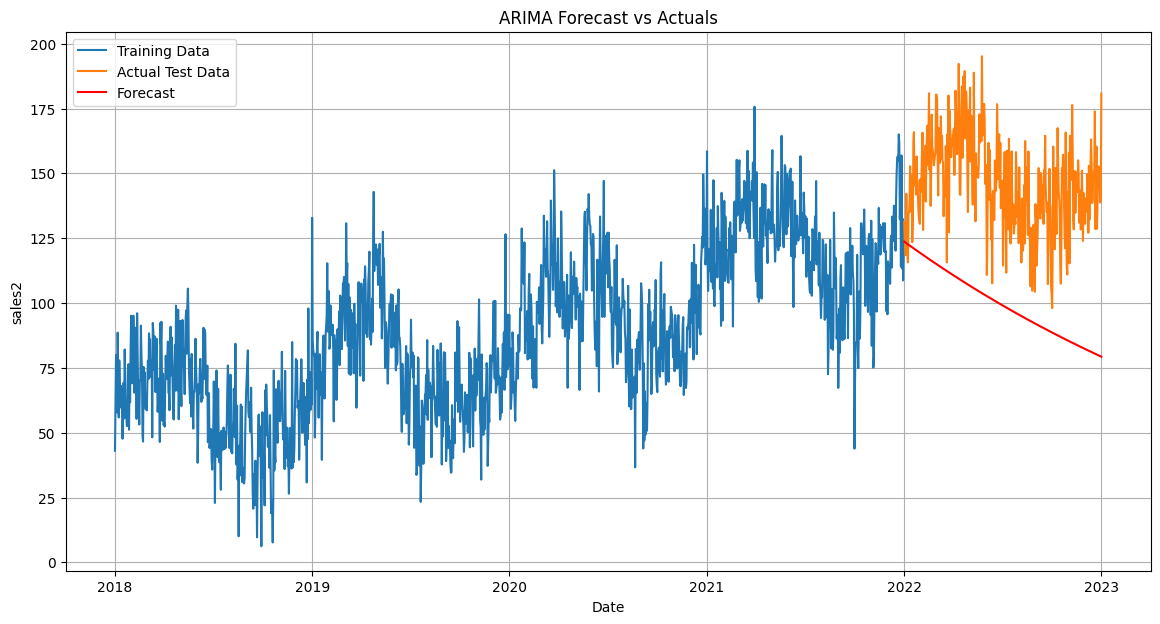

Mean Squared Error (MSE): 2486.0365565209363
Root Mean Squared Error (RMSE): 49.86017004103512
Mean Absolute Error (MAE): 46.276141028809874
Mean Absolute Percentage Error (MAPE): 30.939670735139263%


In [32]:
def test_sarima_on_holdout(data, column_name, train_size=0.8, order=(1, 0, 1), seasonal_order=(2, 0, 3, 12)):
    train_size = int(len(data) * train_size)
    train, test = data[:train_size], data[train_size:]
    
    model = SARIMAX(train[column_name], order=order)
    model_fit = model.fit()
    
    forecast = model_fit.forecast(steps=len(test))
    results = pd.DataFrame({
        'Actual': test[column_name],
        'Predicted': forecast
    })
    # Plot actual vs forecast
    plt.figure(figsize=(14, 7))
    plt.plot(train[column_name], label='Training Data')
    plt.plot(test.index, results['Actual'], label='Actual Test Data')
    plt.plot(test.index, results['Predicted'], label='Forecast', color='red')
    plt.title('ARIMA Forecast vs Actuals')
    plt.xlabel('Date')
    plt.ylabel(column_name)
    plt.legend()
    plt.grid(True)
    plt.show()

    # Calculate error metrics
    mse = mean_squared_error(results['Actual'], results['Predicted'])
    rmse = sqrt(mse)
    mae = mean_absolute_error(results['Actual'], results['Predicted'])
    mape = np.mean(np.abs((results['Actual'] - results['Predicted']) / results['Actual'])) * 100
    print(f'Mean Squared Error (MSE): {mse}')
    print(f'Root Mean Squared Error (RMSE): {rmse}')
    print(f'Mean Absolute Error (MAE): {mae}')
    print(f'Mean Absolute Percentage Error (MAPE): {mape}%')
    return results, model_fit

data_missing_values_handled = handle_missing_values(data)
results, model_fit = test_sarima_on_holdout(data_missing_values_handled, ts_alt_column)

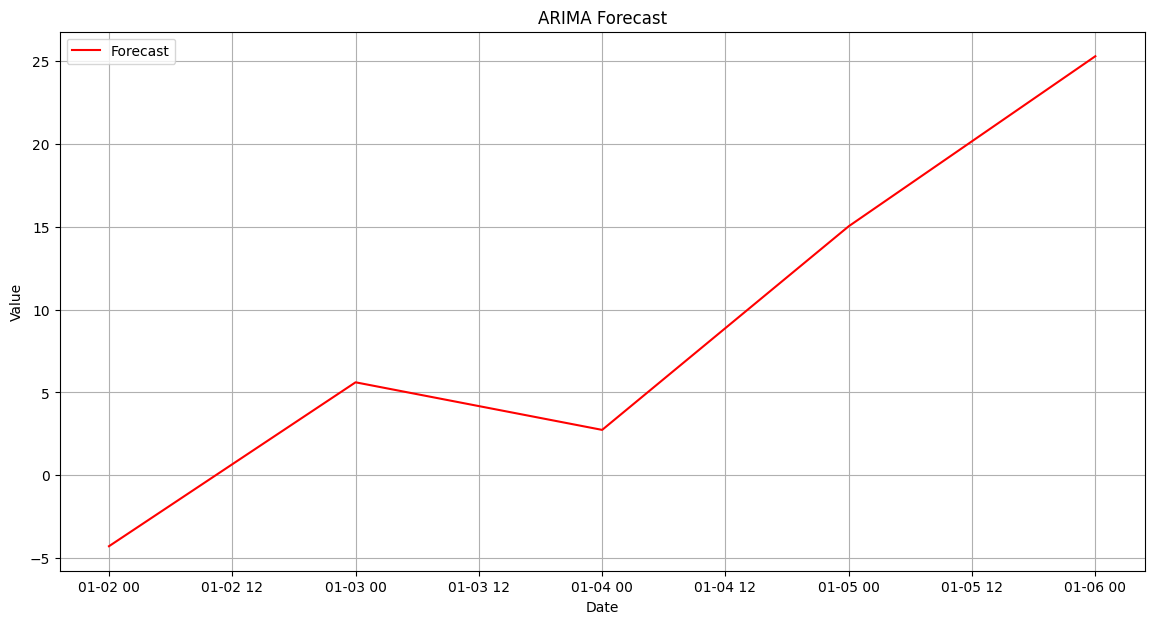

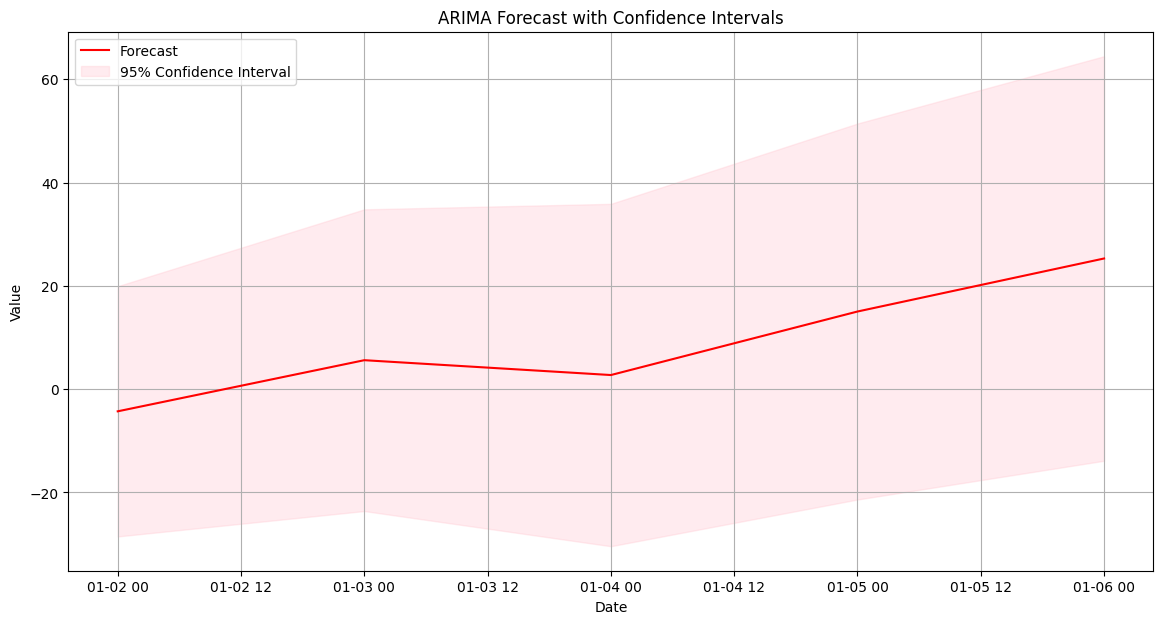

,Forecast,Lower CI,Upper CI
2023-01-02,-4.289317,-28.520972,19.942338
2023-01-03,5.612097,-23.601833,34.826028
2023-01-04,2.737488,-30.413919,35.888896
2023-01-05,15.038676,-21.368348,51.445700
2023-01-06,25.308802,-13.861430,64.479034


In [29]:
def forecast_future(
        model, 
        steps, 
        original_index, 
        frequency='D'  # daily (M for monthly)
    ): 
    forecast = model.forecast(steps=steps)
    last_date = original_index[-1]
    forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=steps, freq=frequency)
    forecast_df = pd.DataFrame(
        {
            'Forecast': forecast
        }, 
        index=forecast_dates
    )
    historical_data = model.model.data.orig_endog
    if len(original_index) != len(historical_data):
        # Use the shorter length to avoid dimension mismatch
        min_length = min(len(original_index), len(historical_data))
        original_index_aligned = original_index[-min_length:]
        historical_data_aligned = historical_data[-min_length:]
    else:
        original_index_aligned = original_index
        historical_data_aligned = historical_data
    plt.figure(figsize=(14, 7))
    # plt.plot(original_index_aligned, historical_data_aligned, label='Historical Data')
    plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecast', color='red')
    plt.title('ARIMA Forecast')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

    pred_conf = model.get_forecast(steps=steps).conf_int()
    lower_conf = pred_conf[:, 0]
    upper_conf = pred_conf[:, 1]
    plt.figure(figsize=(14, 7))
    # plt.plot(original_index_aligned, historical_data_aligned, label='Historical Data')
    plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecast', color='red')
    plt.fill_between(forecast_df.index,
        lower_conf,
        upper_conf,
        color='pink', 
        alpha=0.3, 
        label='95% Confidence Interval'
    )
    plt.title('ARIMA Forecast with Confidence Intervals')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

    forecast_df['Lower CI'] = lower_conf
    forecast_df['Upper CI'] = upper_conf
    return forecast_df

forecast_df = forecast_future(sarima, 5, data.index)
forecast_df.head()